In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Load the dataset
df = pd.read_csv('Airline_Reviews.csv', engine='c', on_bad_lines='skip', nrows=5000, quotechar='"',  delimiter=',')

df = df[['Review_Title', 'Review', 'Recommended']]

# Drop rows with missing values in the important columns (optional, if needed)
df = df.dropna(subset=['Review_Title', 'Review', 'Recommended'])

# Display the first few rows and basic information about the dataset
print(df.head(10))
print(df.info())

                            Review_Title  \
0                "pretty decent airline"   
1                   "Not a good airline"   
2         "flight was fortunately short"   
3    "I will never fly again with Adria"   
4  "it ruined our last days of holidays"   
5              "Had very bad experience"   
6       "worse than the budget airlines"   
7                 "book another company"   
8                 "combined two flights"   
9                    "the crew was nice"   

                                              Review Recommended  
0    Moroni to Moheli. Turned out to be a pretty ...         yes  
1   Moroni to Anjouan. It is a very small airline...          no  
2    Anjouan to Dzaoudzi. A very small airline an...          no  
3    Please do a favor yourself and do not fly wi...          no  
4   Do not book a flight with this airline! My fr...          no  
5    Had very bad experience with rerouted and ca...          no  
6    Ljubljana to Zürich. Firstly, Ljubljana a

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.pipeline import Pipe

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Preprocessing function
def preprocess_text(text):
    doc = nlp(text)
    # Tokenization, lemmatization, and removal of stop words
    tokens = [token.lemma_.lower() for token in doc if token.text not in STOP_WORDS and not token.is_punct]
    return ' '.join(tokens)

# Apply preprocessing to the 'Review' column
df['Processed_Review'] = df['Review'].apply(preprocess_text)


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['Recommended'], test_size=0.3, random_state=42)


In [ ]:
import spacy
from spacy.training import Example

# Define your training data in the format SpaCy expects
train_data = [(text, label) for text, label in zip(X_train, y_train)]

# Set up a blank text classification model and train it
nlp = spacy.blank("en")

# Define the configuration for the textcat component
config = {
    "model": {
        "@architectures": "spacy.TextCatBOW.v3",
        "exclusive_classes": True,
        "ngram_size": 1,
        "no_output_layer": False
    }
}

text_cat = nlp.add_pipe("textcat", config=config)
text_cat.add_label("positive")
text_cat.add_label("negative")

# Training loop (simplified)
optimizer = nlp.begin_training()
for epoch in range(20):  # Number of epochs
    losses = {}
    for text, label in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, {"cats": {"positive": label == "positive", "negative": label == "negative"}})
        nlp.update([example], drop=0.5, losses=losses)
    print(f"Epoch {epoch+1}: Losses {losses}")

# Save the model
nlp.to_disk("text_classifier_model")


Epoch 1: Losses {'textcat': 875.0}
Epoch 2: Losses {'textcat': 875.0}
Epoch 3: Losses {'textcat': 875.0}
Epoch 4: Losses {'textcat': 875.0}
Epoch 5: Losses {'textcat': 875.0}
Epoch 6: Losses {'textcat': 875.0}
Epoch 7: Losses {'textcat': 875.0}
Epoch 8: Losses {'textcat': 875.0}
Epoch 9: Losses {'textcat': 875.0}
Epoch 10: Losses {'textcat': 875.0}
Epoch 11: Losses {'textcat': 875.0}
Epoch 12: Losses {'textcat': 875.0}
Epoch 13: Losses {'textcat': 875.0}
Epoch 14: Losses {'textcat': 875.0}
Epoch 15: Losses {'textcat': 875.0}
Epoch 16: Losses {'textcat': 875.0}
Epoch 17: Losses {'textcat': 875.0}
Epoch 18: Losses {'textcat': 875.0}
Epoch 19: Losses {'textcat': 875.0}
Epoch 20: Losses {'textcat': 875.0}


In [ ]:
import spacy
from spacy.training import Example

# Initialize a blank English model
nlp = spacy.blank("en")

# Add the text classification component with the required configuration
text_cat = nlp.add_pipe("textcat", config={
    "model": {
        "@architectures": "spacy.TextCatBOW.v3",
        "exclusive_classes": True,  # Indicates that each text should belong to only one category
        "ngram_size": 1,            # Use unigrams (1-grams) for text representation
        "no_output_layer": False    # Ensure there is an output layer
    }
})

# Add labels to the text classifier
text_cat.add_label("positive")
text_cat.add_label("negative")

# Prepare training data (format: list of tuples (text, {"cats": {"label1": bool, "label2": bool}}))
train_data = [
    ("I love this product!", {"cats": {"positive": True, "negative": False}}),
    ("This is the worst experience ever.", {"cats": {"positive": False, "negative": True}}),
    # Add more examples here
]

# Training loop
optimizer = nlp.begin_training()
for epoch in range(20):
    losses = {}
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.5, losses=losses)  # Adjust dropout rate
    print(f"Epoch {epoch+1}: Losses {losses}")

# Save the trained model
nlp.to_disk("text_classifier_model")


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Epoch 1: Losses {'textcat': 0.5005002617835999}
Epoch 2: Losses {'textcat': 0.48273324966430664}
Epoch 3: Losses {'textcat': 0.4660736322402954}
Epoch 4: Losses {'textcat': 0.44982215762138367}
Epoch 5: Losses {'textcat': 0.43391837179660797}
Epoch 6: Losses {'textcat': 0.41835489869117737}
Epoch 7: Losses {'textcat': 0.4031340926885605}
Epoch 8: Losses {'textcat': 0.3882605731487274}
Epoch 9: Losses {'textcat': 0.3737449496984482}
Epoch 10: Losses {'textcat': 0.3596018999814987}
Epoch 11: Losses {'textcat': 0.3458418846130371}
Epoch 12: Losses {'textcat': 0.3324725925922394}
Epoch 13: Losses {'textcat': 0.3195012956857681}
Epoch 14: Losses {'textcat': 0.30695921182632446}
Epoch 15: Losses {'textcat': 0.29486626386642456}
Epoch 16: Losses {'textcat': 0.28323349356651306}
Epoch 17: Losses {'textcat': 0.2720654010772705}
Epoch 18: Losses {'textcat': 0.26136084645986557}
Epoch 19: Losses {'textcat': 0.25111496448516846}
Epoch 20: Losses {'textcat': 0.2413194477558136}


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Create a pipeline for Random Forest
pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameters to search
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [10, 20]
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [10, 20],
                         'randomforestclassifier__n_estimators': [100, 200]})

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = grid_search.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8433333333333334
Classification Report:
               precision    recall  f1-score   support

          no       0.85      0.94      0.89      1008
         yes       0.84      0.65      0.73       492

    accuracy                           0.84      1500
   macro avg       0.84      0.79      0.81      1500
weighted avg       0.84      0.84      0.84      1500



In [ ]:
from sklearn.model_selection import train_test_split

# Convert 'Recommended' column to labels (e.g., 'positive' or 'negative')
df['Recommended'] = df['Recommended'].apply(lambda x: 'positive' if x == 'Yes' else 'negative')

# Use 'Review' as the text and 'Recommended' as the label
texts = df['Review'].tolist()
labels = df['Recommended'].tolist()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
import spacy
from spacy.training import Example

# Initialize a blank English model
nlp = spacy.blank("en")

# Add the text classification component to the pipeline
text_cat = nlp.add_pipe("textcat", config={
    "model": {
        "@architectures": "spacy.TextCatBOW.v3",
        "exclusive_classes": True,
        "ngram_size": 1,
        "no_output_layer": False
    }
})
text_cat.add_label("positive")
text_cat.add_label("negative")

# Prepare training data
train_data = [(text, {"cats": {"positive": label == "positive", "negative": label == "negative"}}) for text, label in zip(X_train, y_train)]

# Training loop
optimizer = nlp.begin_training()
for epoch in range(5):
    losses = {}
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.5, losses=losses)
    print(f"Epoch {epoch+1}: Losses {losses}")

# Save the trained model
nlp.to_disk("text_classifier_model")


Epoch 1: Losses {'textcat': 2.1913556753977885}
Epoch 2: Losses {'textcat': 0.0059799156505494465}
Epoch 3: Losses {'textcat': 0.0014226460504832834}
Epoch 4: Losses {'textcat': 0.0002048446472083553}
Epoch 5: Losses {'textcat': 2.989826347344116e-05}


In [ ]:
print("Unique classes in y_true:", set(y_true))
print("Unique classes in y_pred:", set(y_pred))


Unique classes in y_true: {'negative'}
Unique classes in y_pred: {'negative'}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
nlp = spacy.load("text_classifier_model")

# Predict labels for the test set
def predict(texts):
    preds = []
    for text in texts:
        doc = nlp(text)
        preds.append(max(doc.cats, key=doc.cats.get))
    return preds

# Get true and predicted labels
y_true = y_test
y_pred = predict(X_test)

# Generate and display classification report
report = classification_report(y_true, y_pred, target_names=["negative", "negative"])
print("Classification Report:\n", report)

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["positive", "negative"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "negative"], yticklabels=["positive", "negative"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

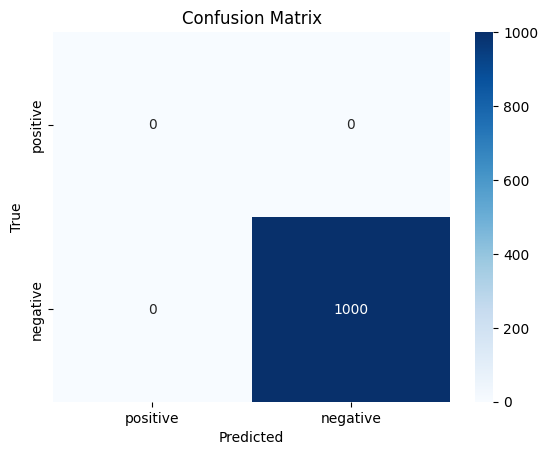

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your true and predicted labels
cm = confusion_matrix(y_true, y_pred, labels=["positive", "negative"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "negative"], yticklabels=["positive", "negative"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_scores)  # y_scores are the predicted probabilities
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from wordcloud import WordCloud

positive_reviews = ' '.join([text for text, label in zip(X_train, y_train) if label == 'positive'])
negative_reviews = ' '.join([text for text, label in zip(X_train, y_train) if label == 'negative'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')

plt.show()


ValueError: We need at least 1 word to plot a word cloud, got 0.